In [ ]:
!pip install -U numpyro --quiet;

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from functools import partial

from jax import jit, vmap
import jax.numpy as jnp
from jax import random

import matplotlib.pyplot as plt
import time

In [ ]:
numpyro.set_host_device_count(4)

In [ ]:
key = random.PRNGKey(1)

In [ ]:
@partial(jit, static_argnums=(1,2))
def assumed_dgp(t1, batch_size=1, n_obs=100, key=None):
  w = dist.Normal(0, 1).sample(key=key, sample_shape=(batch_size, n_obs + 2))
  x = w[:, 2:] + t1 * w[:, 1:-1]
  return x

In [ ]:
# TODO: TERRIBLE IMPLEMENTATION ... RUN ONCE AT START SO WHO CARES
# @partial(jit, static_argnums=(3,4))
def true_dgp(w=-0.736, rho=0.9, sigma_v=0.36, batch_size=1, n_obs=100, key=None):
  h_mat = jnp.zeros((batch_size, n_obs))
  y_mat = jnp.zeros((batch_size, n_obs))

  w_vec = jnp.repeat(w, batch_size)
  rho_vec = jnp.repeat(rho, batch_size)
  sigma_v_vec = jnp.repeat(sigma_v, batch_size)

  key, subkey = random.split(key)
  h_mat = h_mat.at[:, 0].set(w_vec + dist.Normal(0, 1).sample(key=subkey, sample_shape=(batch_size,)) * sigma_v_vec)
  key, subkey = random.split(key)
  y_mat = y_mat.at[:, 0].set(jnp.exp(h_mat[:, 0]/2) * dist.Normal(0, 1).sample(key=subkey, sample_shape=(batch_size,)))

  # TODO?
  for i in range(1, n_obs):
    key, subkey = random.split(key)
    h_mat = h_mat.at[:, i].set(w_vec + rho_vec * h_mat[:, i-1] + dist.Normal(0, 1).sample(key=subkey, sample_shape=(batch_size,)) * sigma_v_vec)
    key, subkey = random.split(key)
    y_mat = y_mat.at[:, i].set(jnp.exp(h_mat[:, i]/2)*dist.Normal(0, 1).sample(key=subkey, sample_shape=(batch_size,)))

  return y_mat

In [ ]:
partial(jit, static_argnums=(1,))
def autocov(x, lag=1):
  x = jnp.atleast_2d(x)
  # In R this is normalized with x.shape[1]
  if lag == 0:
    C = jnp.mean(x[:, :] ** 2, axis=1)
  else:
    C = jnp.mean(x[:, lag:] * x[:, :-lag], axis=1)

  return C


In [ ]:
@jit
def summ_stats(x):
  s0 = autocov(x, lag=0)
  s1 = autocov(x, lag=1)
  return jnp.squeeze(jnp.array([s0, s1]))

In [ ]:
@partial(jit, static_argnums=(1))
def simulation_wrapper(params, batch_size=1, key=None):
  x_sim = assumed_dgp(params, batch_size=batch_size, key=key)
  sim_sum = summ_stats(x_sim)
  return sim_sum.reshape((batch_size, -1))

In [ ]:
true_params = jnp.array([-0.736, 0.9, 0.36])
n_obs = 100

In [ ]:
key, subkey = random.split(key)
x_obs = summ_stats(true_dgp(*true_params, n_obs=n_obs, key=subkey))
summary_dims = len(x_obs)

In [ ]:
prior = dist.Uniform(low=-1.0, high=1.0)

In [ ]:
!pip install -U flowjax --quiet;

In [ ]:
from flowjax.flows import CouplingFlow
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import StandardNormal
from flowjax.train_utils import train_flow

In [ ]:
from numpyro.distributions.util import validate_sample
class FlowNumpyro(dist.Distribution):
    def __init__(self, flow=None, theta=None, standardisation_params=None):
        self.flow = flow
        self.theta = theta
        super(FlowNumpyro, self).__init__()
        
    def sample(self, num_samples=1):
        return self.flow.sample(num_samples)

    @validate_sample
    def log_prob(self, value):
        ll = self.flow.log_prob(value, condition=self.theta)
        return ll

In [ ]:
def model(x_obs_standard, prior, density_estimator, laplace_var=None, standardisation_params=None, key=None):
    theta = numpyro.sample('theta', prior)
    theta_dims = len(standardisation_params['theta_mean'])
    laplace_mean = jnp.zeros(len(x_obs_standard))

    if laplace_var is None:
        laplace_var = jnp.ones(len(x_obs_standard))

    # flow_sims = 100 
    key, subkey = random.split(key)
    # if density_estimator is not None:
    theta_standard = numpyro.deterministic('theta_standard', (theta - standardisation_params['theta_mean']) / standardisation_params['theta_std'])
        # samples = density_estimator.sample(subkey, condition=jnp.tile(theta_standard, flow_sims).reshape(-1, theta_dims))
        # flow_samples_std = numpyro.deterministic('flow_std', jnp.std(samples, axis=0))
    # else:
        # flow_samples_std = numpyro.deterministic('flow_std', jnp.std(simulation_wrapper(theta, flow_sims, key=subkey), axis=0))  # TODO! BAD

    adj_params = numpyro.sample('adj_params', dist.Laplace(laplace_mean, laplace_var))
    x_adj = numpyro.deterministic('x_adj', x_obs_standard - adj_params)
    if density_estimator is not None:
        x_adj_sample = numpyro.sample('x_adj_sample', FlowNumpyro(density_estimator, theta=theta_standard), obs=x_adj)
    else:
        x_adj_sample = x_adj

    return x_adj_sample

In [ ]:
@jit
def generate_simulations(theta, key):
    x_sim = simulation_wrapper(theta, key=key) 
    return x_sim

generate_simulations_vmap = vmap(generate_simulations, in_axes=(0, 0))

In [ ]:
x_obs = jnp.array([0.01, 0])

In [ ]:
tic = time.time()

In [ ]:
num_rounds = 10
num_sims_per_round = 1000
thinning = 10
num_warmup = 1000
num_chains = 4
theta_dims = 1  # TODO: SET SMARTER
# summary_dims = len(x_obs)

x_sims_all = jnp.empty((0, summary_dims))
thetas_all = jnp.empty((0, theta_dims))
flow = None

init_params = {
    'theta': jnp.repeat(jnp.array([0.0]), num_chains).reshape(num_chains, -1),
    'adj_params': jnp.repeat(jnp.array([0.0]), num_chains).reshape(num_chains, -1)
}

x_obs_standard = x_obs

standardisation_params = {
    'theta_mean': jnp.empty(theta_dims),
    'theta_std': jnp.empty(theta_dims),
    'x_sims_mean': jnp.empty(summary_dims),
    'x_sims_std': jnp.empty(summary_dims)
}
for i in range(num_rounds):

    nuts_kernel = NUTS(model, target_accept_prob=0.95)  # INCREASED FOR ROBUSTNESS
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=round((num_sims_per_round*thinning)/num_chains), thinning=thinning, num_chains=num_chains)
    key, subkey1, subkey2 = random.split(key, 3)
    laplace_var = 0.3 * jnp.abs(x_obs_standard)  # TODO: In testing...
    mcmc.run(subkey1, x_obs_standard, prior=prior, density_estimator=flow, 
             laplace_var=laplace_var,
             standardisation_params=standardisation_params, key=subkey2,
             init_params=init_params
             )

    # set init_params for next round MCMC to final round vals
    key, subkey = random.split(key)
    rand_idx = random.randint(subkey, (num_chains,), 0, num_sims_per_round)
    for k,_ in init_params.items():
        init_params[k] = mcmc.get_samples()[k][-rand_idx]

    print('init_params: ', init_params)
    thetas = mcmc.get_samples()['theta']

    sim_keys = random.split(key, num_sims_per_round)
    x_sims = jnp.squeeze(generate_simulations_vmap(thetas, sim_keys))

    x_sims_all = jnp.append(x_sims_all, x_sims.reshape(-1, summary_dims), axis=0)
    thetas_all = jnp.append(thetas_all, thetas.reshape(-1, theta_dims), axis=0)

    # standardise simulated summaries
    standardisation_params['x_sims_mean'] = jnp.mean(x_sims_all, axis=0)
    standardisation_params['x_sims_std'] = jnp.std(x_sims_all, axis=0)
    x_sims_all_standardised = (x_sims_all - standardisation_params['x_sims_mean'] ) / standardisation_params['x_sims_std']
    x_obs_standard = (x_obs - standardisation_params['x_sims_mean']) / standardisation_params['x_sims_std']

    # standardise parameters
    standardisation_params['theta_mean'] = jnp.mean(thetas_all, axis=0)
    standardisation_params['theta_std'] = jnp.std(thetas_all, axis=0)    
    print('standardisation_params: ', standardisation_params)

    thetas_all_standardised = (thetas_all - standardisation_params['theta_mean']) / standardisation_params['theta_std']

    key, subkey = random.split(key)
    flow = CouplingFlow(
        key=subkey,
        base_dist=StandardNormal((2,)),  # TODO: MAGIC
        transformer=RationalQuadraticSpline(knots=10, interval=5), # 10 spline segments over [-5, 5].
        cond_dim=thetas_all_standardised.shape[1]
        )

    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x_sims_all_standardised, thetas_all_standardised)


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([-0.7060344 , -0.6773417 , -0.6773417 , -0.27408034], dtype=float32), 'adj_params': DeviceArray([[ 0.9142928 , -0.0531044 ],
             [-1.3145514 , -0.85130024],
             [-1.3145514 , -0.85130024],
             [ 1.1110625 , -1.9746652 ]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.3265404], dtype=float32), 'theta_std': DeviceArray([0.42699233], dtype=float32), 'x_sims_mean': DeviceArray([ 1.2919441, -0.3333062], dtype=float32), 'x_sims_std': DeviceArray([0.28287017, 0.4514331 ], dtype=float32)}


100%|██████████| 50/50 [00:24<00:00,  2.04it/s, train=0.833, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.11990452, -0.22076792,  0.2929293 , -0.16365474], dtype=float32), 'adj_params': DeviceArray([[-3.7413146 , -0.05961748],
             [-3.343661  ,  0.40661725],
             [-3.0595317 , -0.07590154],
             [-3.431978  ,  0.27341777]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.14660509], dtype=float32), 'theta_std': DeviceArray([0.38178143], dtype=float32), 'x_sims_mean': DeviceArray([ 1.1688248 , -0.15163141], dtype=float32), 'x_sims_std': DeviceArray([0.26673818, 0.40676168], dtype=float32)}


100%|██████████| 50/50 [00:19<00:00,  2.60it/s, train=0.895, val=0]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([-0.02779144, -0.02345473, -0.06434804, -0.13604575], dtype=float32), 'adj_params': DeviceArray([[-4.159043  , -0.02902613],
             [-3.5577426 ,  0.04858218],
             [-3.8064547 ,  0.07272687],
             [-3.8537955 ,  0.04503388]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.09505562], dtype=float32), 'theta_std': DeviceArray([0.3284108], dtype=float32), 'x_sims_mean': DeviceArray([ 1.1178277 , -0.09950649], dtype=float32), 'x_sims_std': DeviceArray([0.24391201, 0.35335335], dtype=float32)}


 48%|████▊     | 24/50 [00:18<00:20,  1.29it/s, train=1.11, val=1.06 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([-0.04096961, -0.1782347 , -0.0367257 ,  0.1209048 ], dtype=float32), 'adj_params': DeviceArray([[-4.0628605 ,  0.04092268],
             [-4.0495834 ,  0.0974158 ],
             [-3.1542463 , -0.0123358 ],
             [-3.3775256 , -0.03925044]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.07328936], dtype=float32), 'theta_std': DeviceArray([0.2938732], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0936912 , -0.07676278], dtype=float32), 'x_sims_std': DeviceArray([0.2289127 , 0.32032076], dtype=float32)}


 56%|█████▌    | 28/50 [00:21<00:16,  1.33it/s, train=1.24, val=1.35 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.05729854,  0.03344715, -0.03811246, -0.23397529], dtype=float32), 'adj_params': DeviceArray([[-3.1734574e+00,  1.4689862e-03],
             [-3.7012293e+00,  6.6048369e-02],
             [-4.4943972e+00,  6.0140952e-02],
             [-3.7277474e+00,  5.7957161e-02]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.05932311], dtype=float32), 'theta_std': DeviceArray([0.2701186], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0784249 , -0.06207443], dtype=float32), 'x_sims_std': DeviceArray([0.21793963, 0.2969835 ], dtype=float32)}


 34%|███▍      | 17/50 [00:23<00:45,  1.39s/it, train=1.37, val=1.62 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.03487003, -0.06800574,  0.14248908,  0.05652952], dtype=float32), 'adj_params': DeviceArray([[-4.69322824e+00,  3.07834558e-02],
             [-4.36676502e+00,  5.27680181e-02],
             [-3.16974092e+00, -1.21513836e-01],
             [-5.55297995e+00,  3.10624880e-03]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.04759294], dtype=float32), 'theta_std': DeviceArray([0.2525714], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0678958 , -0.05002302], dtype=float32), 'x_sims_std': DeviceArray([0.20844483, 0.2799335 ], dtype=float32)}


 34%|███▍      | 17/50 [00:20<00:39,  1.19s/it, train=1.47, val=1.61 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.07824004, -0.03475404, -0.05716485,  0.09979904], dtype=float32), 'adj_params': DeviceArray([[-5.1545696e+00,  2.2981651e-02],
             [-4.6016493e+00,  5.5050753e-02],
             [-4.5275702e+00,  7.8380108e-03],
             [-4.9137025e+00,  5.0795595e-03]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.04189505], dtype=float32), 'theta_std': DeviceArray([0.23782338], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0611339 , -0.04340127], dtype=float32), 'x_sims_std': DeviceArray([0.20171659, 0.2660388 ], dtype=float32)}


 30%|███       | 15/50 [00:21<00:49,  1.40s/it, train=1.56, val=1.49 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([0.03081477, 0.01057816, 0.14783728, 0.04091311], dtype=float32), 'adj_params': DeviceArray([[-4.8309889e+00,  5.5550057e-02],
             [-4.2987618e+00,  6.1847229e-02],
             [-4.9560814e+00, -1.2160389e-03],
             [-4.7347865e+00,  1.6349733e-02]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.0383057], dtype=float32), 'theta_std': DeviceArray([0.22658324], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0559462 , -0.04055766], dtype=float32), 'x_sims_std': DeviceArray([0.19654132, 0.25495243], dtype=float32)}


 32%|███▏      | 16/50 [00:22<00:48,  1.44s/it, train=1.62, val=1.67 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.00075138, -0.26767457,  0.20254993, -0.29040122], dtype=float32), 'adj_params': DeviceArray([[-4.7177877 , -0.02121566],
             [-4.0371284 ,  0.00615392],
             [-4.1045637 , -0.00794315],
             [-4.67277   ,  0.04613724]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.03399471], dtype=float32), 'theta_std': DeviceArray([0.21703473], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0507035 , -0.03627261], dtype=float32), 'x_sims_std': DeviceArray([0.19206029, 0.2452724 ], dtype=float32)}


 46%|████▌     | 23/50 [00:25<00:30,  1.13s/it, train=1.67, val=1.74 (Max patience reached)]


  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

init_params:  {'theta': DeviceArray([ 0.19281876,  0.02572763, -0.17890131, -0.01307148], dtype=float32), 'adj_params': DeviceArray([[-4.615194  , -0.01084379],
             [-4.8976345 ,  0.03944454],
             [-4.974009  ,  0.03161382],
             [-3.323352  ,  0.01483518]], dtype=float32)}
standardisation_params:  {'theta_mean': DeviceArray([-0.03177953], dtype=float32), 'theta_std': DeviceArray([0.20889255], dtype=float32), 'x_sims_mean': DeviceArray([ 1.0469272 , -0.03331112], dtype=float32), 'x_sims_std': DeviceArray([0.18831249, 0.23778155], dtype=float32)}


 54%|█████▍    | 27/50 [00:28<00:24,  1.06s/it, train=1.71, val=1.74 (Max patience reached)]


In [ ]:
# SAMPLE FINAL POSTERIOR
nuts_kernel = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=25000, num_chains=4, thinning=1)  # TODO: MADE NUMBERS UP
key, subkey1, subkey2 = random.split(key, 3)
laplace_var = 0.3 * jnp.abs(x_obs_standard)  # TODO: In testing...
mcmc.run(subkey1, x_obs_standard, prior, density_estimator=flow,
         standardisation_params=standardisation_params,
         laplace_var=laplace_var,
         init_params=init_params, 
         key=subkey2)


  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

  0%|          | 0/26000 [00:00<?, ?it/s]

In [ ]:
key, subkey = random.split(key)
# numpyro.render_model(model, model_args=(x_obs, proposal, flow, subkey), render_distributions=True)

In [ ]:
toc = time.time()
print('time: ', toc - tic)

time:  1231.091866493225


In [ ]:
mcmc.print_summary()  


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
adj_params[0]     -4.81      0.70     -4.77     -5.91     -3.71  39276.23      1.00
adj_params[1]     -0.00      0.06     -0.00     -0.10      0.10  51129.18      1.00
        theta     -0.00      0.11     -0.00     -0.18      0.17  44248.95      1.00

Number of divergences: 0


In [ ]:
import arviz as az
# az.style.use("arviz-doc")

In [ ]:
for k, v in mcmc.get_samples().items():
  print(v.shape)

(100000, 2)
(100000,)
(100000, 1)
(100000, 2)


In [ ]:
inference_data = az.from_numpyro(mcmc)

In [ ]:
folder_name = "vis/rsnl_misspec_ma1"

In [ ]:
import os
isExist = os.path.exists(folder_name)
if not isExist:
  os.makedirs(folder_name)

In [ ]:
inference_data.posterior.adj_params

<xarray.DataArray 'adj_params' (chain: 4, draw: 25000, adj_params_dim_0: 2)>
array([[[-4.6834106e+00, -9.4361873e-03],
        [-4.3767257e+00,  4.8538330e-03],
        [-4.6251769e+00,  1.7893195e-02],
        ...,
        [-5.4624162e+00, -8.9932680e-03],
        [-5.3759618e+00,  1.3632892e-02],
        [-5.5315657e+00, -3.9002330e-03]],

       [[-4.2705016e+00, -1.1654055e-02],
        [-4.2300057e+00,  2.7165845e-02],
        [-4.8275537e+00,  6.1204387e-03],
        ...,
        [-5.1074157e+00,  9.7782835e-02],
        [-5.9757190e+00, -5.2855900e-03],
        [-4.1127472e+00,  2.1321313e-02]],

       [[-4.7409115e+00, -1.6217481e-02],
        [-5.1586280e+00, -1.6156264e-03],
        [-5.4349089e+00, -6.1676104e-02],
        ...,
        [-5.0452580e+00, -7.9844795e-02],
        [-5.1353765e+00,  1.1363930e-02],
        [-5.0476432e+00,  1.4342545e-02]],

       [[-4.3698893e+00,  4.0010717e-02],
        [-4.2432890e+00,  5.8843579e-02],
        [-3.9728971e+00,  6.7446776e-02],
        ...,
        [-5.3829184e+00,  1.9592840e-02],
        [-4.8483672e+00,  5.3017322e-02],
        [-4.6080084e+00,  5.7988536e-02]]], dtype=float32)
Coordinates:
  * chain             (chain) int64 0 1 2 3
  * draw              (draw) int64 0 1 2 3 4 5 ... 24995 24996 24997 24998 24999
  * adj_params_dim_0  (adj_params_dim_0) int64 0 1

In [ ]:
theta_plot = {}
var_name_map = {}
reference_values = {}

for i in range(theta_dims):
    key_name = 'theta' + str(i+1)
    theta_plot[key_name] = inference_data.posterior.theta.values.flatten()
    var_name_map[key_name] = fr'$\theta$'
for i in range(summary_dims):
    key_name = 'adj param' + str(i+1)
    theta_plot[key_name] = inference_data.posterior.adj_params.values[:, :, i].flatten()
    var_name_map[key_name] = fr'$\gamma_{i+1}$'

# for ii, k in enumerate(theta_plot):
    # if 'theta' in var_name_map[k]:
    # var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
    #     reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

In [ ]:
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super;
!pip install -U latex --quiet;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [ ]:
labeller = az.labels.MapLabeller(var_name_map=var_name_map)

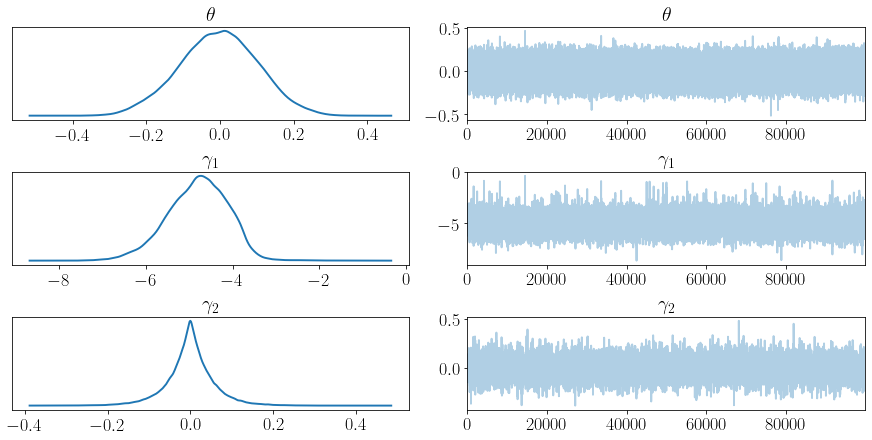

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['text.usetex'] = True

axes = az.plot_trace(theta_plot,
              compact=False,
              labeller=labeller,
              plot_kwargs={'textsize': 18},
              );

for ii, axes_ii in enumerate(axes):
    for jj, axes_jj in enumerate(axes_ii):
        axes_jj.title.set_fontsize(20)

plt.savefig(f"{folder_name}_traceplots.pdf")
plt.show()

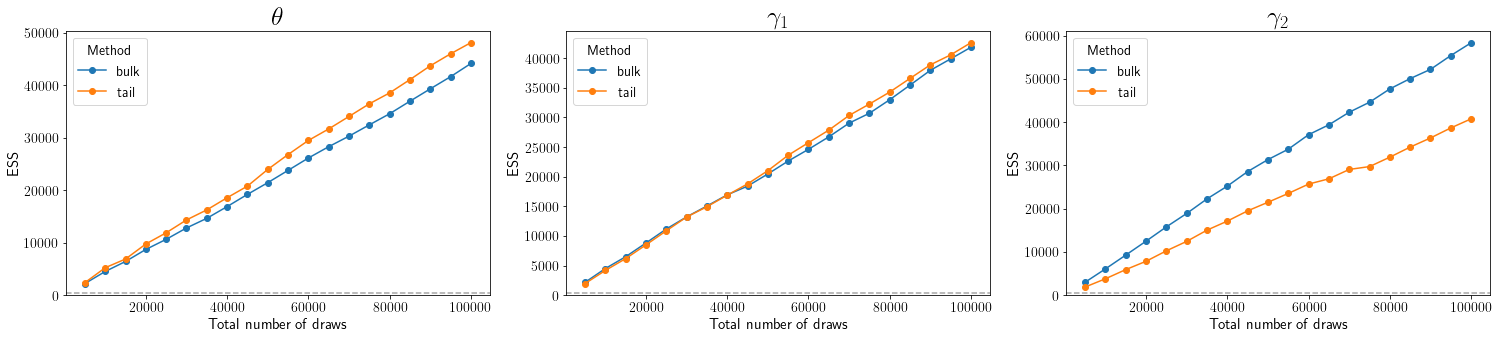

In [ ]:
plt.rcParams['text.usetex'] = True

axes = az.plot_ess(theta_plot, kind="evolution", labeller=labeller);
for ii, axes_ii in enumerate(axes):
    # for jj, axes_jj in enumerate(axes_ii):
    axes_ii.title.set_fontsize(26)
plt.savefig(f"{folder_name}_ess_plots.pdf")
plt.show()

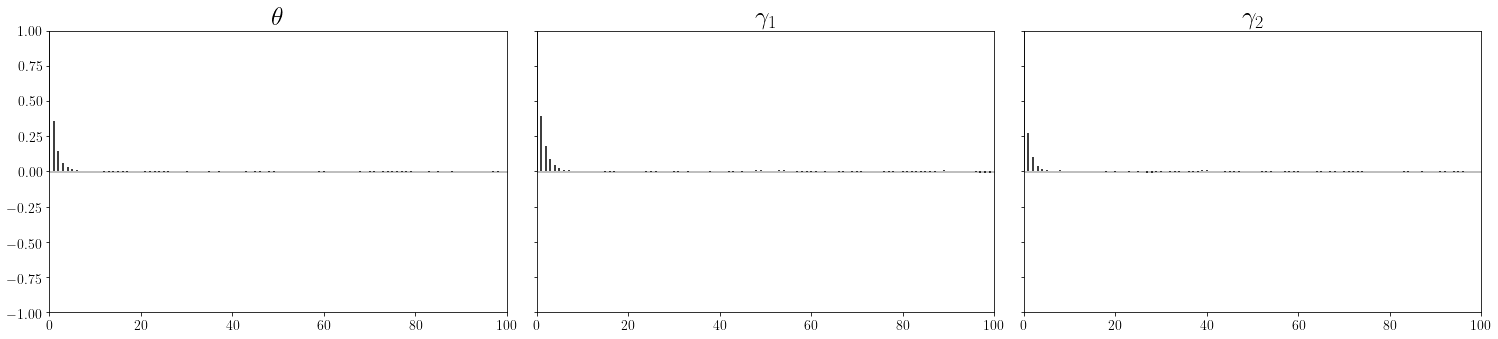

In [ ]:
plt.rcParams['text.usetex'] = True

axes = az.plot_autocorr(theta_plot, combined=True, labeller=labeller);
for ii, axes_ii in enumerate(axes):
    # for jj, axes_jj in enumerate(axes_ii):
    axes_ii.title.set_fontsize(26)

plt.savefig(f"{folder_name}_autocorr.pdf")


In [ ]:
# az.plot_pair(inference_data, var_names=['adj_params', 'theta'], kind='kde', reference_values={'theta': 0.0, 'adj_params 0': -5.0, 'adj_params 1': 0.0}, reference_values_kwargs={'color': 'red'})
# plt.savefig(f"{folder_name}_pair.png")


In [ ]:
# theta_plot = {}
# for i in range(theta_dims):
#     theta_plot['theta' + str(i+1)] = inference_data.posterior.theta[i, :].values.flatten()

# var_name_map = {}
# reference_values = {}
# for ii, k in enumerate(theta_plot):
#     var_name_map[k] = fr'$\{k[:-1]}_{k[-1]}$'
#     reference_values[var_name_map[k]] = true_params[ii]  # why does ref_vals match labels and not data? ah well

In [ ]:
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super;
!pip install -U latex --quiet;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive is already the newest version (2019.20200218-1).
texlive-fonts-recommended is already the newest version (2019.20200218-1).
texlive-latex-extra is already the newest version (2019.202000218-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


Text(0.5, 1.0, '$b_0 = 0.01$')

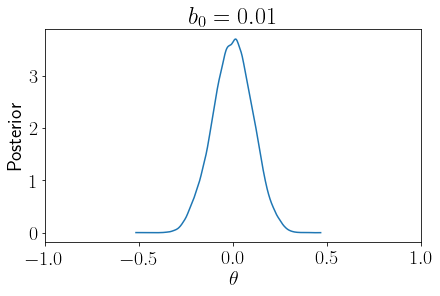

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
az.plot_dist(inference_data.posterior.theta,
            #  plot_kwargs={'plot_kwargs': }
             )
plt.xlabel(r"$\theta$", fontsize=20)
plt.xlim([-1, 1])

plt.ylabel("Posterior", fontsize=20)

plt.title("$b_0 = 0.01$")

In [ ]:
import numpy as np
import pickle as pkl

with open('rsnl_misspec_ma1_theta.pkl', 'wb') as f: pkl.dump(inference_data.posterior.theta, f)

In [ ]:
with open('rsnl_contaminated_normal_adj_params.pkl', 'wb') as f: pkl.dump(inference_data.posterior.adj_params, f)

In [ ]:
# assuming have SNL data in colab ... lazy
with open('snl_misspec_ma1_theta.pkl', 'rb') as f:
    theta_snl = pkl.load(f)

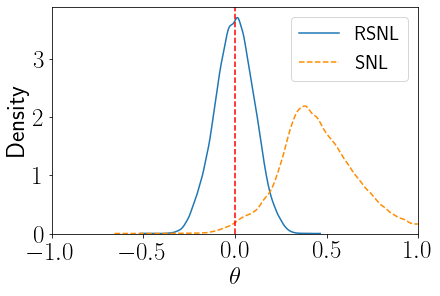

In [ ]:
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})
plt.rcParams['xtick.labelsize'] = 25
az.plot_dist(inference_data.posterior.theta,
             label='RSNL'
            #  plot_kwargs={'plot_kwargs': }
             )
az.plot_dist(theta_snl.values.flatten(),
             color=mcolors.CSS4_COLORS['darkorange'],
             plot_kwargs={'linestyle': 'dashed'},
             label='SNL'
             )
plt.xlabel(r"$\theta$", fontsize=25)
plt.xlim([-1, 1])
plt.ylim(bottom=0)
plt.legend(fontsize=20)
plt.ylabel("Density", fontsize=25)
plt.axvline(x=0, color='red', linestyle='dashed')
# plt.title("$b_0 = 0.01$")
plt.savefig('misspec_ma1_posterior.pdf')

In [ ]:
 laplace_mean = jnp.zeros(2)
 laplace_var = 0.3 * jnp.abs(x_obs_standard)
 key, subkey = random.split(key)

 prior_samples = dist.Laplace(laplace_mean, laplace_var).sample(subkey, (10000,))

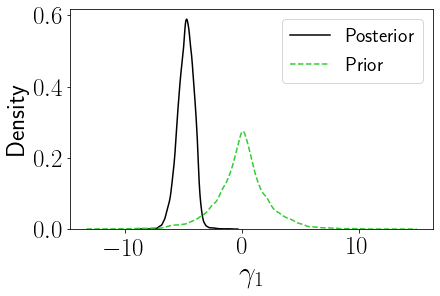

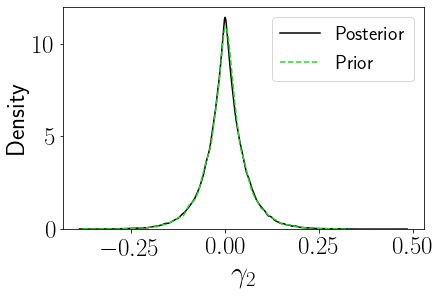

In [ ]:
import matplotlib.colors as mcolors

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 25})

for i in range(2):  # lazy
    az.plot_dist(inference_data.posterior.adj_params[:, :, i].values.flatten(),
                label='Posterior',
                color='black')
    az.plot_dist(prior_samples[:, i], 
                 color=mcolors.CSS4_COLORS['limegreen'],
                 plot_kwargs={'linestyle': 'dashed'},
                 label='Prior')
    plt.xlabel(rf"$\gamma_{i+1}$", fontsize=30)
    plt.ylabel("Density", fontsize=25)
    plt.ylim(bottom=0)
    plt.legend(fontsize=20)
    # plt.title("$b_0 = 0.01$")
    plt.savefig(f'misspec_ma1_adj_param{i+1}.pdf')
    plt.show()